# EDSR

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Activation, Input #changed 'keras.' to 'tensorflow.keras.'
from tensorflow.keras.models import Sequential, Model #changed 'keras.' to 'tensorflow.keras.'
from tensorflow.keras import optimizers #changed 'keras.' to 'tensorflow.keras.'
import cv2
import math
import glob
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display
import sys
from keras.models import load_model
import mtcnn
from mtcnn.mtcnn import MTCNN
import random
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.applications import resnet
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import sklearn
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
target_shape = (160, 160)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Convolution2DTranspose


In [ ]:
depth = 16
scale = 4
downgrade = 'bicubic'

In [8]:
f1 = 9
f2 = 1
f3 = 5

n1 = 64
n2 = 32


init = Input(shape=(24,24,3))
x = Conv2D(64, (9, 9), activation='relu', padding='same', name='level1')(init)
x = Conv2D(32, (1, 1), activation='relu', padding='same', name='level2')(x)

out = Conv2D(3, (5, 5), padding='same', name='output')(x)

model = Model(init, out)

#adam = optimizers.Adam(lr=1e-3)
#model.compile(optimizer=adam, loss='mse')
model.load_weights('SR Weights 2X.h5')
model.summary()

ValueError: Cannot assign to variable level1/kernel:0 due to variable shape (9, 9, 3, 64) and value shape (9, 9, 64, 3) are incompatible

In [ ]:
SR = edsr(scale=scale, num_res_blocks=depth)
SR.load_weights('weights/edsr-16-x4/weights.h5')
for layer in SR.layers:
    layer.trainable = False
SR.summary()

In [ ]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch

def resolve_and_plot(lr):
    lr = tf.image.resize(lr, [24,24], method = 'bicubic')
    #sr = resolve(SR, lr)
    sr = tf.image.resize(lr, [160,160], method = 'bicubic')
    image = tf.image.convert_image_dtype(sr, tf.float32)
    #image = tf.image.per_image_standardization(image)
    return image

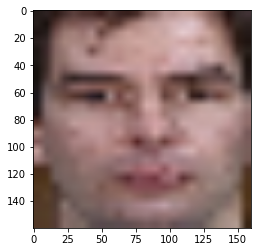

In [3]:
lr = cv2.imread('0000.jpg')
lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
#lr = tf.convert_to_tensor(lr)
lr = tf.image.resize(lr, [24,24], method = 'bicubic')
#lr = tf.image.resize(lr, [36,36])
lr = tf.cast(tf.image.resize(lr, [160,160]), tf.uint8)
#lr = resolve_and_plot(lr)
plt.imshow(lr)

In [ ]:
lr = cv2.imread('0000.jpg')
lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
lr = cv2.resize(lr, (36,36), interpolation=cv2.INTER_CUBIC)
lr = resolve_single(SR, lr)

lr = np.array(lr)
lr = cv2.resize(lr, (160,160), interpolation=cv2.INTER_CUBIC)
plt.imshow(lr)

In [ ]:
FECNN = keras.models.load_model('../keras-facenet-master/keras-facenet-master/model/keras/model/facenet_keras.h5')
FECNN.load_weights('../keras-facenet-master/keras-facenet-master/model/keras/weights/facenet_keras_weights.h5')
for layer in FECNN.layers:
    layer.trainable = False

In [ ]:
temp = keras.models.load_model('../keras-facenet-master/keras-facenet-master/model/keras/model/facenet_keras.h5')
temp.load_weights('../keras-facenet-master/keras-facenet-master/model/keras/weights/facenet_keras_weights.h5')
temp.summary()

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (160,160)

directory = "../low-res-face-recognition/Dataset/final_gen_data_209/train"
train_ds = image_dataset_from_directory(
    directory, label_mode=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True, seed=0, validation_split=None, subset=None,
    interpolation='bicubic', follow_links=False)
directory = "../low-res-face-recognition/Dataset/final_gen_data_209/val"
valid_ds = image_dataset_from_directory(
    directory, label_mode=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True, seed=0, validation_split=None, subset=None,
    interpolation='bicubic', follow_links=False)

In [ ]:
def hr(x):
    image = tf.image.convert_image_dtype(x, tf.float32)
    image = tf.image.per_image_standardization(image)
    image = FECNN(image)
    return image

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(
    lambda x: (resolve_and_plot(x), hr(x))
)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x: (resolve_and_plot(x), hr(x))
)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
input_img = Input(shape=(160,160,3))
A6 = temp(input_img)
SRFECNN = Model(input_img, A6)
opt = optimizers.Adam()
    
SRFECNN.compile(
    optimizer=opt,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
SRFECNN.summary()

In [ ]:
model_checkpoint_callback = ModelCheckpoint(filepath='../twobranch_extension/weights.h5',
                                            save_weights_only = True,
                                            period = 1,
                                            verbose = 1,
                                            save_best_only=False)

In [ ]:
train_loss = []
val_loss = []
train_acc_arr = []
val_acc_arr = []

In [ ]:
for ite in range(45):
    if ite == 30:
        opt = optimizers.Adam(learning_rate = 0.0001)
        SRFECNN.compile(
            optimizer=opt,
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()])
    if ite == 40:
        opt = optimizers.Adam(learning_rate = 0.00001)
        SRFECNN.compile(
            optimizer=opt,
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()])
    if ite > 0:
        SRFECNN.load_weights('../twobranch_extension/weights.h5')
        
    history = SRFECNN.fit(train_ds, epochs=1, validation_data=valid_ds, callbacks = [model_checkpoint_callback])
    
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

    i=0
    j=1
    temp = []
    data = np.zeros((2090,512))
    train_labels = np.zeros((2090,))
    for filename in os.listdir('../low-res-face-recognition/Dataset/final_gen_data_209/train'):
        lr = cv2.imread(os.path.join('../low-res-face-recognition/Dataset/final_gen_data_209/train',filename))
        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)

        lr = cv2.resize(lr, (24,24), interpolation=cv2.INTER_CUBIC)
        #lr = resolve_single(SR, lr)
        #lr = np.array(lr)
        lr = cv2.resize(lr, (160,160), interpolation=cv2.INTER_CUBIC)

        lr = lr.astype('float32')
        mean, std = lr.mean(), lr.std()
        lr = (lr - mean) / std

        lr = np.array([lr])
        lr = tf.convert_to_tensor(lr)
        vec1 = SRFECNN.predict(lr)
        vec1 = vec1.flatten() 
        data[i] = vec1
        train_labels[i] = int(i/10)
        i += 1
    
    #STANDARDIZATION

    mean_arr = []
    std_arr = []
    for i in range(len(data[0])):
        x = data[:,i]
        x = x.astype('float32')
        mean, std = x.mean(), x.std()
        x = (x - mean) / std
        mean_arr.append(mean)
        std_arr.append(std)
        data[:,i] = x
        
    i=0
    j=1
    temp = []
    val = np.zeros((418,512))
    val_labels = np.zeros((418,))
    for filename in os.listdir('../low-res-face-recognition/Dataset/final_gen_data_209/val'):
        lr = cv2.imread(os.path.join('../low-res-face-recognition/Dataset/final_gen_data_209/val',filename))
        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)

        lr = cv2.resize(lr, (24,24), interpolation=cv2.INTER_CUBIC)
        #lr = resolve_single(SR, lr)
        #lr = np.array(lr)
        lr = cv2.resize(lr, (160,160), interpolation=cv2.INTER_CUBIC)

        lr = lr.astype('float32')
        mean, std = lr.mean(), lr.std()
        lr = (lr - mean) / std

        lr = np.array([lr])
        lr = tf.convert_to_tensor(lr)
        vec1 = SRFECNN.predict(lr)
        vec1 = vec1.flatten()
        val[i] = vec1
        val_labels[i] = int(i/2)
        i += 1
        
    #STANDARDIZATION

    for i in range(len(val[0])):
        x = val[:,i]
        x = x.astype('float32')
        x = (x - mean_arr[i]) / std_arr[i]
        val[:,i] = x
    
    sc_X = StandardScaler()
    X_Train = sc_X.fit_transform(data)
    X_val = sc_X.transform(val)

    # Fitting the Logistic Regression into the Training set
    classifier = LogisticRegression(max_iter=10**20)
    classifier.fit(X_Train, train_labels)
    
    Y_Pred_train = classifier.predict(X_Train)
    train_acc = accuracy_score(train_labels, Y_Pred_train)
    train_acc_arr.append(train_acc)

    Y_Pred = classifier.predict(X_val)
    val_acc = accuracy_score(val_labels, Y_Pred)
    val_acc_arr.append(val_acc)
    
    print(ite,train_acc_arr[ite],val_acc_arr[ite],train_loss[ite],val_loss[ite])

In [ ]:
with open('../train_loss.txt', 'w') as f:
    for item in train_loss:
        f.write("%s\n" % item)
with open('../val_loss.txt', 'w') as f:
    for item in val_loss:
        f.write("%s\n" % item)
with open('../train_acc.txt', 'w') as f:
    for item in train_acc_arr:
        f.write("%s\n" % item)
with open('../val_acc.txt', 'w') as f:
    for item in val_acc_arr:
        f.write("%s\n" % item)

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(train_acc_arr, label='Training Accuracy')
plt.plot(val_acc_arr, label='Validation Accuracy')
plt.legend(loc='lower right', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('epoch', fontsize = 20)

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Mean Squared Error', fontsize = 20)
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,7])
plt.xlabel('epoch', fontsize = 20)
plt.show()

In [ ]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
start = time.time()
i=0
FP=0
TN=0
FN=0
accuracy = 0
t=7.5
b=0
x = []
from keras_vggface.vggface import VGGFace
FECNN = VGGFace()
def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]
#SRFECNN.load_weights('../../twobranch_extension/unfreezed15_lr=0.001.100-0.46.h5')
for filename in os.listdir('../../SRtrain/train'):
    img = cv2.imread(os.path.join('../../SRtrain/train',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (36,36), interpolation=cv2.INTER_CUBIC)
    #img = resolve_single(SR,img)
    #img = np.array(img)
    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    img = img.astype('float32')
    mean, std = img.mean(), img.std()
    img = (img - mean) / std
    img = np.array([img])
    img = tf.convert_to_tensor(img)
    vec = FECNN.predict(img)
    #vec = vec/np.linalg.norm(vec)5
    #print(vec)
    #break
    x.append(vec.flatten())
    #vec1 = vec1/np.linalg.norm(vec1)
    #a = []
    '''for j in range(50):
        k = 's' + str(j)
        vec2 = dic[k]/np.linalg.norm(dic[k])
        dist = tf.reduce_sum(K.sqrt(K.square(vec2-vec1)))
        a.append(dist)'''  
#print(x)
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
#plt.ylim([-30,30])
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('FECNN Features PCA', fontsize = 20)
colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
k=[0,2,6,8,9]
x = 10
for i in range(10):
    ax.scatter(principalDf.loc[range((i*x),((i*x)+x)), 'principal component 1']
               , principalDf.loc[range((i*x),((i*x)+x)), 'principal component 2']
               , c = colors[i]
               , s = 50)
#ax.legend(targets)
ax.grid()

In [ ]:
principalDf = pd.DataFrame(data = test2d
             , columns = ['principal component 1', 'principal component 2'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
#plt.ylim([-30,30])
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('FECNN Features PCA', fontsize = 20)
colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
k=[0,2,6,8,9]
x = 5
for i in range(10):
    ax.scatter(principalDf.loc[range((i*x),((i*x)+x)), 'principal component 1']
               , principalDf.loc[range((i*x),((i*x)+x)), 'principal component 2']
               , c = colors[i]
               , s = 50)
#ax.legend(targets)
ax.grid()

In [ ]:
import matplotlib
matplotlib.__version__


In [ ]:
#THRESHOLD

In [ ]:
print(b)

In [ ]:
kmean = KMeans(n_clusters=2)
labels = kmean.fit_predict(b)
print(labels)

In [ ]:
labels_1=[]
labels_0=[]

for i in range(len(labels)):
    if(labels[i]==1):
        labels_1.append(b[i])
    else:
        labels_0.append(b[i])
print(len(labels_1))
print(len(labels_0))

In [ ]:
kmean.cluster_centers_

In [ ]:
#plt.ylim(0,1)
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Image number', fontsize = 15)
ax.set_ylabel('Distance', fontsize = 15)
ax.set_title('KMeans clustering', fontsize = 20)
ax.scatter(range(0,56),labels_0,color='red')
ax.scatter(range(56,100),labels_1,color='blue')
ax.scatter([20,53],[[0.37287224],
       [0.11982424]],marker='x',linewidths=3,color='purple')
ax.plot([0,66],[0.235,0.235],color='green')
ax.legend(['Threshold','Img not in DB','Img in DB','Cluster centroids'])
plt.show()

In [ ]:
c = b[:40]
mini = min(c)
#print(mini)
d = b[40:]
maxi = max(d)
#print(c) maximum = 0.23314758
print(d) #minimum = 0.23771875,0.25001103

In [ ]:
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import RMSprop
classifier_model = tf.keras.models.Sequential()
classifier_model.add(tf.keras.layers.Dense(195, input_shape = (512,), activation = 'softmax'))#tfa.activations.mish))
#classifier_model.add(tf.keras.layers.Dropout(0.5))
#classifier_model.add(tf.keras.layers.Dense(195, activation = 'softmax'))

In [ ]:
#classifier_model = build_classifier_model()
opt = optimizers.Adam()
classifier_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [ ]:
train_oh_labels = tf.one_hot(train_labels, 195)
val_oh_labels = tf.one_hot(val_labels, 195)

In [ ]:
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=5, min_lr=0.000001)
history = classifier_model.fit(x = data, y = train_oh_labels, validation_data = (val, val_oh_labels), batch_size=1950, epochs=1000)

In [ ]:
y_pred = classifier_model.predict(test)
pred = [np.argmax(x) for x in y_pred]
test_acc = accuracy_score(test_labels, pred)
print("Test Accuracy: ", test_acc)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_Train = sc_X.fit_transform(data)
X_Test = sc_X.transform(val)

# Fitting the Logistic Regression into the Training set

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
classifier = LogisticRegression(solver = 'lbfgs', max_iter=10**19)
classifier.fit(X_Train, train_labels)

# Predicting the test set results

Y_Pred = classifier.predict(X_Test)

# Making the Confusion Matrix 

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_labels, Y_Pred)

In [ ]:
#print(Y_Pred)
X_Test = sc_X.transform(data)
Y_Pred_train = classifier.predict(X_Test)
test_acc = accuracy_score(train_labels, Y_Pred_train)
print("Train Accuracy: ", test_acc)

X_Test = sc_X.transform(val)
Y_Pred = classifier.predict(X_Test)
test_acc = accuracy_score(val_labels, Y_Pred)
print("Val Accuracy: ", test_acc)

#shuffled = np.zeros((300,513))
#shuffled[:,:512] = test
#shuffled[:,512] = test_labels
#np.random.shuffle(shuffled)
#test_shuffled = shuffled[:,:512]
#labels_shuffled = shuffled[:,512]
#X_Test = sc_X.transform(test)
#Y_Pred = classifier.predict(X_Test)
#test_acc = accuracy_score(test_labels, Y_Pred)
#print("Test Accuracy: ", test_acc)

In [ ]:
X_Test = sc_X.transform(test)
Y_Pred = classifier.predict(X_Test)
test_acc = accuracy_score(test_labels, Y_Pred)
print("Test Accuracy: ", test_acc)

In [ ]:
print(Y_Pred)

In [ ]:
detector = MTCNN()
import mtcnn
from mtcnn.mtcnn import MTCNN
def process(pixels):
    global flag
    results = detector.detect_faces(pixels)
    if len(results) == 0:
        flag = 1
        return 0
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    img = pixels[y1:y2, x1:x2]
    img = cv2.resize(img, (160,160), interpolation=cv2.INTER_CUBIC)
    return img

test_labels = np.zeros((10,))
b = []
i=0
test = np.zeros((10,512))
for filename in os.listdir('../../../test'):
    lr = cv2.imread(os.path.join('../../../test',filename))
    lr = process(lr)
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    
    lr = cv2.resize(lr, (24,24), interpolation=cv2.INTER_CUBIC)
    lr = resolve_single(SR, lr)
    lr = np.array(lr)
    lr = cv2.resize(lr, (160,160), interpolation=cv2.INTER_CUBIC)
    
    lr = lr.astype('float32')
    mean, std = lr.mean(), lr.std()
    lr = (lr - mean) / std
    
    lr = np.array([lr])
    lr = tf.convert_to_tensor(lr)
    vec1 = SRFECNN.predict(lr)
    vec1 = vec1.flatten() 
    test[i] = vec1
    #test_labels[i] = int(i/5)
    i += 1

In [ ]:
#STANDARDIZATION

for i in range(len(test[0])):
    x = test[:,i]
    x = x.astype('float32')
    x = (x - mean_arr[i]) / std_arr[i]
    test[:,i] = x

In [ ]:
test_labels = [98,98,98,98,98,99,99,99,99,99]
print(np.array(test_labels))
os.listdir('../../../test')

In [ ]:
#SVM

In [ ]:
#TRAIN DATA

In [ ]:
i=0
j=1
temp = []
data = np.zeros((1950,512))
train_labels = np.zeros((1950,))
for filename in os.listdir('../low-res-face-recognition/Dataset/final_gen_data/train'):
    hr = cv2.imread(os.path.join('../low-res-face-recognition/Dataset/final_gen_data/train',filename))
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    
    hr = hr.astype('float32')
    mean, std = hr.mean(), hr.std()
    hr = (hr - mean) / std
    hr = np.array([hr])
    hr = tf.convert_to_tensor(hr)
    vec = FECNN.predict(hr)
    vec = vec.flatten()
    data[i] = vec
    train_labels[i] = int(i/10)
    i += 1

In [ ]:
i=0
j=1
temp = []
data = np.zeros((2090,512))
train_labels = np.zeros((2090,))
for filename in os.listdir('../low-res-face-recognition/Dataset/final_gen_data_209/train'):
    lr = cv2.imread(os.path.join('../low-res-face-recognition/Dataset/final_gen_data_209/train',filename))
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    
    lr = cv2.resize(lr, (36,36), interpolation=cv2.INTER_CUBIC)
    lr = resolve_single(SR, lr)
    lr = np.array(lr)
    lr = cv2.resize(lr, (160,160), interpolation=cv2.INTER_CUBIC)
    
    lr = lr.astype('float32')
    mean, std = lr.mean(), lr.std()
    lr = (lr - mean) / std
    
    lr = np.array([lr])
    lr = tf.convert_to_tensor(lr)
    vec1 = SRFECNN.predict(lr)
    vec1 = vec1.flatten() 
    data[i] = vec1
    train_labels[i] = int(i/10)
    i += 1

In [ ]:
#STANDARDIZATION

mean_arr = []
std_arr = []
for i in range(len(data[0])):
    x = data[:,i]
    x = x.astype('float32')
    mean, std = x.mean(), x.std()
    x = (x - mean) / std
    mean_arr.append(mean)
    std_arr.append(std)
    data[:,i] = x

In [ ]:
#VAL DATA

In [ ]:
i=0
j=1
temp = []
val = np.zeros((390,512))
val_labels = np.zeros((390,))
for filename in os.listdir('../low-res-face-recognition/Dataset/final_gen_data/val'):
    hr = cv2.imread(os.path.join('../low-res-face-recognition/Dataset/final_gen_data/val',filename))
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    
    hr = hr.astype('float32')
    mean, std = hr.mean(), hr.std()
    hr = (hr - mean) / std
    hr = np.array([hr])
    hr = tf.convert_to_tensor(hr)
    vec = FECNN.predict(hr)
    vec = vec.flatten()
    val[i] = vec
    val_labels[i] = int(i/2)
    i += 1

In [ ]:
i=0
j=1
temp = []
val = np.zeros((418,512))
val_labels = np.zeros((418,))
for filename in os.listdir('../low-res-face-recognition/Dataset/final_gen_data_209/val'):
    lr = cv2.imread(os.path.join('../low-res-face-recognition/Dataset/final_gen_data_209/val',filename))
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    
    lr = cv2.resize(lr, (36,36), interpolation=cv2.INTER_CUBIC)
    lr = resolve_single(SR, lr)
    lr = np.array(lr)
    lr = cv2.resize(lr, (160,160), interpolation=cv2.INTER_CUBIC)
    
    lr = lr.astype('float32')
    mean, std = lr.mean(), lr.std()
    lr = (lr - mean) / std
    
    lr = np.array([lr])
    lr = tf.convert_to_tensor(lr)
    vec1 = SRFECNN.predict(lr)
    vec1 = vec1.flatten()
    val[i] = vec1
    val_labels[i] = int(i/2)
    i += 1

In [ ]:
#STANDARDIZATION

for i in range(len(val[0])):
    x = val[:,i]
    x = x.astype('float32')
    x = (x - mean_arr[i]) / std_arr[i]
    val[:,i] = x

In [ ]:
#TEST DATA

In [ ]:
test_labels = np.zeros((627,))
b = []
i=0
test = np.zeros((627,512))
for filename in os.listdir('../low-res-face-recognition/Dataset/final_gen_data_209/test'):
    lr = cv2.imread(os.path.join('../low-res-face-recognition/Dataset/final_gen_data_209/test',filename))
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    
    lr = cv2.resize(lr, (16,16), interpolation=cv2.INTER_CUBIC)
    lr = resolve_single(SR, lr)
    lr = np.array(lr)
    lr = cv2.resize(lr, (160,160), interpolation=cv2.INTER_CUBIC)
    
    lr = lr.astype('float32')
    mean, std = lr.mean(), lr.std()
    lr = (lr - mean) / std
    
    lr = np.array([lr])
    lr = tf.convert_to_tensor(lr)
    vec1 = SRFECNN.predict(lr)
    vec1 = vec1.flatten() 
    test[i] = vec1
    test_labels[i] = int(i/3)
    i += 1

In [ ]:
#STANDARDIZATION

for i in range(len(test[0])):
    x = test[:,i]
    x = x.astype('float32')
    x = (x - mean_arr[i]) / std_arr[i]
    test[:,i] = x

In [ ]:
svc_model = svm.SVC(kernel = 'linear', gamma='scale', probability = True) 
svc_model.fit(data, train_labels)

## Train Accuracy
pred = svc_model.predict(data)
train_acc = accuracy_score(train_labels, pred)
print("Training Accuracy: ", train_acc)

## Test Accuracy
pred = svc_model.predict(test)
test_acc = accuracy_score(test_labels, pred)
print("Test Accuracy: ", test_acc)

In [ ]:
print(test_labels)

In [ ]:
model = KNeighborsClassifier(n_neighbors=20)
model.fit(data, train_labels)

## Train Accuracy
pred = model.predict(data)
train_acc = accuracy_score(train_labels, pred)
print("Training Accuracy: ", train_acc)

pred = model.predict(test)
test_acc = accuracy_score(test_labels, pred)
print("Test Accuracy: ", test_acc)

from sklearn.svm import SVC

#dataset = datasets.load_iris()

model = SVC(kernel = 'linear',probability = True)
model.fit(data, labels)
print(model)

#expected = dataset.target
#predicted = model.predict(dataset.data)

#print(metrics.classification_report(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))

In [ ]:
dist1 = np.linalg.norm(data[3] - test[1])
dist2 = np.linalg.norm(data[3] - test[10])
print(dist1,dist2)

In [ ]:
predicted = svc_model.predict(test)
print(metrics.classification_report(test_labels, predicted))
print(metrics.confusion_matrix(test_labels, predicted))

In [ ]:
x = StandardScaler().fit_transform(data)
pca = PCA(n_components=2)
data2d = pca.fit_transform(x)

x = StandardScaler().fit_transform(test)
pca = PCA(n_components=2)
test2d = pca.fit_transform(x)
#print(principalComponents)


In [ ]:
test2d[:,0] *= -1 

In [ ]:
print(test2d[:,0])

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with

# Take the first two features. We could avoid this by using a two-dim dataset
X = data2d
y = train_labels

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()